In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [114]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

from sqlalchemy import extract
from sqlalchemy import distinct

In [9]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [10]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [11]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [12]:
# Save references to each table
#Map Measurement & Station classes
Measurement = Base.classes.measurement
Station = Base.classes.station

In [13]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

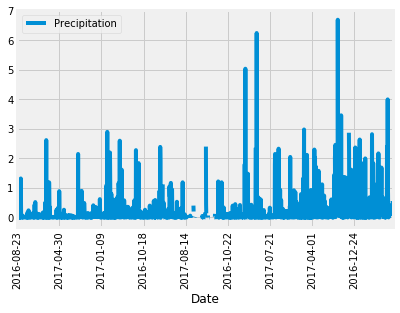

In [20]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

#Find the last date data was recorded
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

#Calculate the date 1 year ago from the last data point in the database
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
last_year

# Query data and precipitation scores 
prcp_last_year = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= last_year).all()
prcp_last_year

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_last_year, columns=('Date', 'Precipitation'))


# Sort the dataframe by date
prcp_df.sort_values(by=['Date']).set_index(['Date'])

prcp_df

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(x='Date', y='Precipitation', rot=90)

In [21]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [23]:
# Design a query to show how many stations are available in this dataset?
# session.query(func.count(distinct(Measurement.station))).all()

station_count = session.query(Station.station).count()
station_count

9

In [74]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [49]:
active_stations_df = pd.DataFrame(active_stations, columns=('Station', 'Observation Counts'))
active_stations_df.set_index('Station')

,Counts
Station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [69]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
top_station = active_stations_df.iloc[0,0]

ts_temp_stat = session.query(func.min(Measurement.tobs),
                         func.max(Measurement.tobs),
                         func.avg(Measurement.tobs)).\
            filter(Measurement.station==top_station).all()

ts_temp_stat


[(54.0, 85.0, 71.66378066378067)]

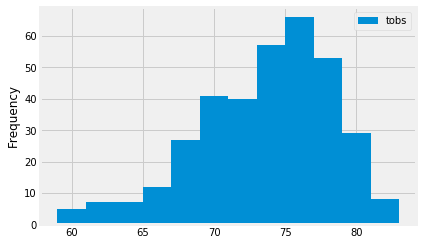

In [79]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_last_yr = session.query(Measurement.tobs).\
        filter(Measurement.station == top_station).\
        filter(Measurement.date >= last_year).all()

temp_df = pd.DataFrame(temp_last_yr, columns=['tobs'])
temp_df

temp_df.plot.hist(bins=12)

![precipitation](Images/station-histogram.png)

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [128]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_last_yr = dt.date(2018, 2, 28) - dt.timedelta(days=365)
end_last_yr = dt.date(2018, 3, 5) - dt.timedelta(days=365)

tmin, tave, tmax = calc_temps(start_last_yr.strftime("%Y-%m-%d"), end_last_yr.strftime("%Y-%m-%d"))[0]
print(tmin, tavg, tmax)

64.0 72.02777777777777 78.0


/Users/MichelleW/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


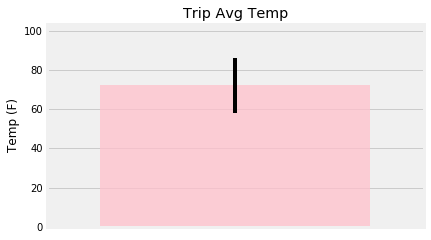

In [108]:
# Plot the results from your previous query as a bar chart. 
fig, ax = plt.subplots()
x = 1
# Use the average temperature for the y value
y = tavg
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
error = tmax - tmin

calc_temp_bar = ax.bar(x, y, yerr=error, color='pink', align='center', alpha=0.75)
# Use "Trip Avg Temp" as your Title
ax.set_title('Trip Avg Temp')
ax.set_ylabel('Temp (F)')
ax.set_xticks(range(x))
ax.margins(.2, .2)
fig.tight_layout()
fig.show()


In [110]:
# Calculate the total amount(sum) of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
#Join tables
sel = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, 
       func.sum(Measurement.prcp)]

weather = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_last_yr).\
    filter(Measurement.date <= end_last_yr).\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()

print(weather)

[('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 4.720000000000001), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 4.45), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 4.07), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 2.98), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 2.7399999999999998), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 2.32), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 1.1600000000000001)]


In [112]:
weather_df = pd.DataFrame(weather, columns=('Station', 'Name', 'Latitude', 'Longitude', 'Elevation', 'Total Prcp'))
weather_df.set_index('Station')

,Name,Latitude,Longitude,Elevation,Total Prcp
Station,,,,,
USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,4.72
USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,4.45
USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,4.07
USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,2.98
USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,2.74
USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,2.32
USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.16


## Optional Challenge Assignment

In [124]:
#Identify the average temperature in June (6) for all stations across all years in the dataset
#use sqlalchemy extract to filter for the specific month
june_temps = session.query(Measurement).filter(extract('month', Measurement.date)==6).all()
june_list = []
for temp in june_temps:
    june_list.append(temp.tobs)
    
june_avg_temp = np.mean(june_list)


#Identify the average temperature in December (12) for all stations across all years in the dataset
dec_temps = session.query(Measurement).filter(extract('month', Measurement.date)==12).all()
dec_list = []
for temp in dec_temps:
    dec_list.append(temp.tobs)
    
dec_avg_temp = np.mean(dec_list)

print("June:", june_avg_temp, "Dec:", dec_avg_temp)

June: 74.94411764705882 Dec: 71.04152933421226


In [ ]:
#Perform t-test to determine whether the difference in means is statistically significant

#Will you use a paired t-test, or an upaired t-test? Why?


In [125]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [137]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `vacay_norms`

# Set the start and end date of the trip
start_vacay = '2018-02-28'
end_vacay = '2018-03-05'

# Use the start and end date to create a range of dates 
vacay_dates = pd.date_range(start_vacay, end_vacay, freq='D')

# Stip off the year and save a list of %m-%d strings
vacay_m_d = vacay_dates.strftime('%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
vacay_norms = []
for date in vacay_m_d:
    vacay_norms.append(*daily_normals(date))
    
vacay_norms

[(65.0, 70.65517241379311, 80.0),
 (64.0, 70.0327868852459, 76.0),
 (61.0, 70.36666666666666, 78.0),
 (60.0, 70.06896551724138, 78.0),
 (57.0, 69.27272727272727, 77.0),
 (60.0, 67.89090909090909, 76.0)]

In [150]:
# Load the previous query results into a Pandas DataFrame
vacay_norms_df = pd.DataFrame(vacay_norms, columns=['tmin', 'tavg', 'tmax'])

#add the `trip_dates` range as the `date` index
vacay_norms_df['Date'] = vacay_dates
vacay_norms_df.set_index(['Date'], inplace=True)

vacay_norms_df

,tmin,tavg,tmax
Date,,,
2018-02-28,65.0,70.655172,80.0
2018-03-01,64.0,70.032787,76.0
2018-03-02,61.0,70.366667,78.0
2018-03-03,60.0,70.068966,78.0
2018-03-04,57.0,69.272727,77.0
2018-03-05,60.0,67.890909,76.0


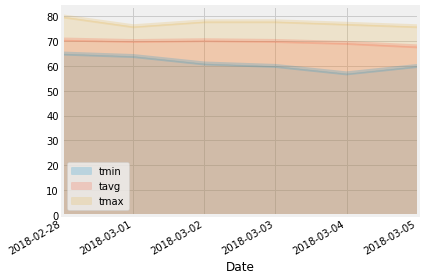

In [152]:
# Plot the daily normals as an area plot with `stacked=False`
vacay_plt = vacay_norms_df.plot.area(stacked=False, alpha=.2, x_compat=True)  #x_compat uncompacts dates and keeps grid for each
plt.tight_layout()
plt.show()